In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import random

In [2]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [3]:
def read_images(file_path):
    """Read MNIST images from IDX file format"""
    with open(file_path, "rb") as f:
        magic, num, rows, cols = np.frombuffer(f.read(16), dtype=">i4")
        images = np.frombuffer(f.read(), dtype=np.uint8).reshape(num, 1, rows, cols)
    return images

In [4]:
def read_labels(file_path):
    """Read MNIST labels from IDX file format"""
    with open(file_path, "rb") as f:
        magic, num = np.frombuffer(f.read(8), dtype=">i4")
        labels = np.frombuffer(f.read(), dtype=np.uint8)
    return labels

In [5]:
def load_augmented_training_data(augmented_path):
    """Load augmented training dataset from .npy files"""
    train_images = np.load(os.path.join(augmented_path, "train_images_augmented.npy"))
    train_labels = np.load(os.path.join(augmented_path, "train_labels_augmented.npy"))

    print(f"Augmented training samples: {len(train_images)}")

    return train_images, train_labels

In [6]:
def load_mnist_data(data_paths, use_augmented=True):
    """Load MNIST dataset - augmented training data and original test data"""
    if use_augmented:
        print("Loading augmented training data...")
        train_images, train_labels = load_augmented_training_data(
            data_paths["augmented_path"]
        )
    else:
        print("Loading original training data...")
        train_images = read_images(data_paths["train_images"])
        train_labels = read_labels(data_paths["train_labels"])

    print("Loading test data...")
    test_images = read_images(data_paths["test_images"])
    test_labels = read_labels(data_paths["test_labels"])

    print(f"Training samples: {len(train_images)}")
    print(f"Test samples: {len(test_images)}")

    return train_images, train_labels, test_images, test_labels

In [7]:
def preprocess_data(
    train_images, train_labels, test_images, test_labels, batch_size=64
):
    """Create PyTorch DataLoaders from numpy arrays"""
    # Check if training images are already normalized (from .npy files)
    if train_images.max() <= 1.0:
        # Already normalized
        train_tensor = torch.tensor(train_images, dtype=torch.float32)
    else:
        # Need to normalize
        train_tensor = torch.tensor(train_images, dtype=torch.float32) / 255.0

    # Normalize test images
    test_tensor = torch.tensor(test_images, dtype=torch.float32) / 255.0

    train_dataset = TensorDataset(
        train_tensor,
        torch.tensor(train_labels, dtype=torch.long),
    )
    test_dataset = TensorDataset(
        test_tensor,
        torch.tensor(test_labels, dtype=torch.long),
    )

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

    return train_loader, test_loader

In [8]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)

        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 320)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [9]:
def train_model(
    model, train_loader, test_loader, device, learning_rate=0.001, epochs=5
):
    """Train the CNN model with one progress bar per epoch"""
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    train_losses = []
    test_accuracies = []

    min_loss_till_now = float("inf")

    for epoch in range(1, epochs + 1):
        model.train()
        epoch_loss = 0
        num_batches = 0

        # Progress bar for this epoch
        batch_pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{epochs}", unit="batch")

        for data, target in batch_pbar:
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            num_batches += 1

            # Update current batch bar
            batch_pbar.set_postfix({"Batch Loss": f"{loss.item():.4f}"})

        avg_epoch_loss = epoch_loss / num_batches
        train_losses.append(avg_epoch_loss)

        if avg_epoch_loss < min_loss_till_now:
            min_loss_till_now = avg_epoch_loss
            torch.save(model.state_dict(), "best_model_adversarial.pth")

        accuracy = test_model(model, test_loader, device, verbose=False)
        test_accuracies.append(accuracy)

        # Print summary after each epoch
        print(
            f"Epoch {epoch}/{epochs} - Loss: {avg_epoch_loss:.4f}, Test Acc: {accuracy:.2f}%"
        )

    return train_losses, test_accuracies

In [10]:
def test_model(model, test_loader, device, verbose=True):
    """Evaluate the model on test data"""
    model.eval()
    test_loss = 0
    correct = 0
    criterion = nn.CrossEntropyLoss(reduction="sum")

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100.0 * correct / len(test_loader.dataset)

    if verbose:
        print(f"\nTest set: Average loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%")

    return accuracy

In [11]:
def get_predictions(model, test_loader, device):
    """Get all predictions and true labels for visualization"""
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1)

            all_preds.extend(pred.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

    return np.array(all_preds), np.array(all_targets)

In [12]:
def visualize_training_progress(train_losses, test_accuracies):
    """Visualize training loss and test accuracy over epochs"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Training Loss
    epochs = range(1, len(train_losses) + 1)
    ax1.plot(epochs, train_losses, "b-", marker="o", linewidth=2, markersize=6)
    ax1.set_title(
        "Training Loss Over Epochs (Adversarial Training)",
        fontsize=14,
        fontweight="bold",
    )
    ax1.set_xlabel("Epoch", fontsize=12)
    ax1.set_ylabel("Loss", fontsize=12)
    ax1.grid(True, alpha=0.3)
    ax1.set_facecolor("#f8f9fa")

    # Test Accuracy
    ax2.plot(epochs, test_accuracies, "g-", marker="s", linewidth=2, markersize=6)
    ax2.set_title(
        "Test Accuracy Over Epochs (Adversarial Training)",
        fontsize=14,
        fontweight="bold",
    )
    ax2.set_xlabel("Epoch", fontsize=12)
    ax2.set_ylabel("Accuracy (%)", fontsize=12)
    ax2.grid(True, alpha=0.3)
    ax2.set_facecolor("#f8f9fa")
    ax2.set_ylim([90, 100])  # Focus on the relevant accuracy range

    plt.tight_layout()
    plt.show()

In [13]:
def visualize_confusion_matrix(y_true, y_pred):
    """Create and display confusion matrix"""
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=range(10),
        yticklabels=range(10),
    )
    plt.title("Confusion Matrix (Adversarial Training)", fontsize=16, fontweight="bold")
    plt.xlabel("Predicted Label", fontsize=12)
    plt.ylabel("True Label", fontsize=12)
    plt.show()

    return cm

In [14]:
def print_classification_report(y_true, y_pred):
    """Print detailed classification metrics"""
    print("\nDetailed Classification Report:")
    print("=" * 50)
    print(
        classification_report(y_true, y_pred, target_names=[str(i) for i in range(10)])
    )

In [15]:
def visualize_sample_predictions(model, test_dataset, device, num_samples=10):
    """Visualize sample predictions vs actual labels"""
    random_indices = random.sample(range(len(test_dataset)), num_samples)

    fig, axes = plt.subplots(2, 5, figsize=(15, 8))
    fig.suptitle(
        "Sample Predictions vs Actual Labels (Adversarial Training)",
        fontsize=16,
        fontweight="bold",
    )

    for i, idx in enumerate(random_indices):
        row = i // 5
        col = i % 5

        image, label = test_dataset[idx]

        # Get prediction
        model.eval()
        with torch.no_grad():
            image_tensor = image.unsqueeze(0).to(device)
            output = model(image_tensor)
            prediction = output.argmax(dim=1).item()

        # Plot
        axes[row, col].imshow(image.squeeze().numpy(), cmap="gray")

        # Color coding: green for correct, red for incorrect
        color = "green" if prediction == label else "red"
        axes[row, col].set_title(
            f"Pred: {prediction}\nActual: {label}", color=color, fontweight="bold"
        )
        axes[row, col].axis("off")

    plt.tight_layout()
    plt.show()

In [16]:
config = {"batch_size": 64, "learning_rate": 0.001, "epochs": 5}

In [17]:
data_paths = {
    "augmented_path": "../dataset/augmented/",  # NEW: Path to augmented data
    "train_images": "../dataset/train-images-idx3-ubyte/train-images-idx3-ubyte",
    "train_labels": "../dataset/train-labels-idx1-ubyte/train-labels-idx1-ubyte",
    "test_images": "../dataset/t10k-images-idx3-ubyte/t10k-images-idx3-ubyte",
    "test_labels": "../dataset/t10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte",
}

In [18]:
print("\nLoading MNIST dataset...")
train_images, train_labels, test_images, test_labels = load_mnist_data(
    data_paths, use_augmented=True  # Set to False to use original data
)


Loading MNIST dataset...
Loading augmented training data...
Augmented training samples: 61000
Loading test data...
Training samples: 61000
Test samples: 10000


In [19]:
print("\nPreprocessing data...")
train_loader, test_loader = preprocess_data(
    train_images,
    train_labels,
    test_images,
    test_labels,
    batch_size=config["batch_size"],
)


Preprocessing data...


In [20]:
test_dataset = TensorDataset(
    torch.tensor(test_images, dtype=torch.float32) / 255.0,
    torch.tensor(test_labels, dtype=torch.long),
)

In [21]:
model = SimpleCNN().to(device)

print(f"\nStarting training for {config['epochs']} epochs...")
train_losses, test_accuracies = train_model(
    model,
    train_loader,
    test_loader,
    device,
    learning_rate=config["learning_rate"],
    epochs=config["epochs"],
)


Starting training for 5 epochs...


Epoch 1/5: 100%|██████████| 954/954 [00:10<00:00, 87.20batch/s, Batch Loss=0.0301] 


Epoch 1/5 - Loss: 0.2909, Test Acc: 97.02%


Epoch 2/5: 100%|██████████| 954/954 [00:10<00:00, 86.90batch/s, Batch Loss=0.1392] 


Epoch 2/5 - Loss: 0.0852, Test Acc: 98.24%


Epoch 3/5: 100%|██████████| 954/954 [00:11<00:00, 84.53batch/s, Batch Loss=0.0590] 


Epoch 3/5 - Loss: 0.0601, Test Acc: 98.63%


Epoch 4/5: 100%|██████████| 954/954 [00:09<00:00, 104.44batch/s, Batch Loss=0.0013]


Epoch 4/5 - Loss: 0.0468, Test Acc: 98.67%


Epoch 5/5: 100%|██████████| 954/954 [00:12<00:00, 75.93batch/s, Batch Loss=0.0643]


Epoch 5/5 - Loss: 0.0397, Test Acc: 98.73%



Generating visualizations...


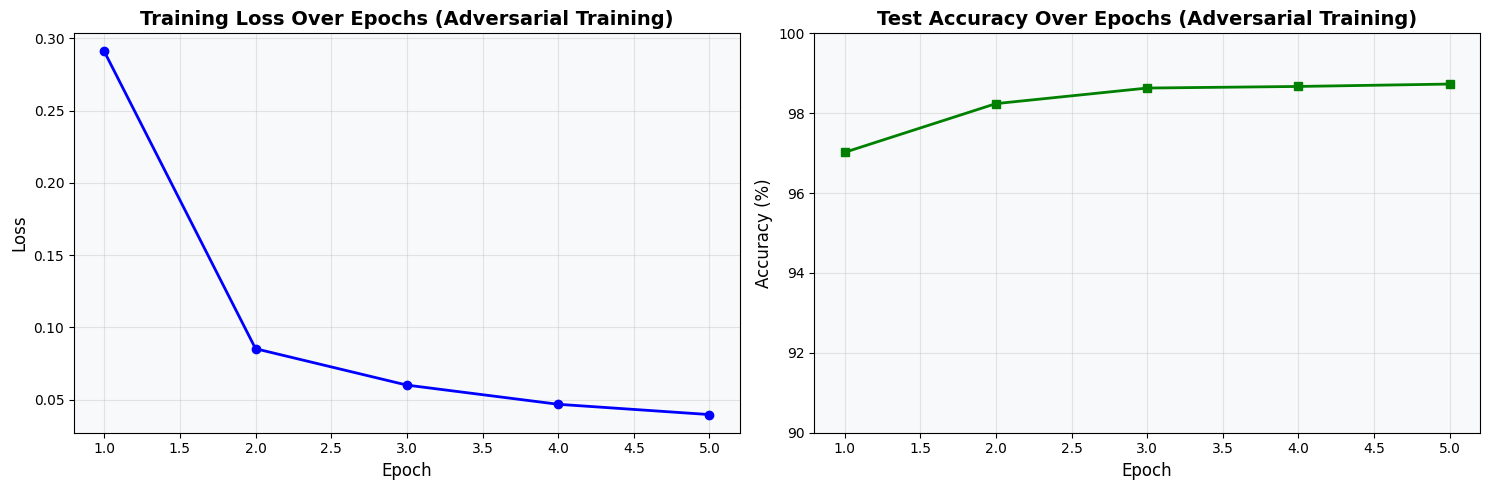

In [22]:
print("\nGenerating visualizations...")
visualize_training_progress(train_losses, test_accuracies)

In [23]:
print("\nFinal evaluation on test set...")
final_accuracy = test_model(model, test_loader, device)


Final evaluation on test set...

Test set: Average loss: 0.0396, Accuracy: 98.73%


In [24]:
print("\nGenerating predictions for confusion matrix...")
y_pred, y_true = get_predictions(model, test_loader, device)


Generating predictions for confusion matrix...



Generating confusion matrix...


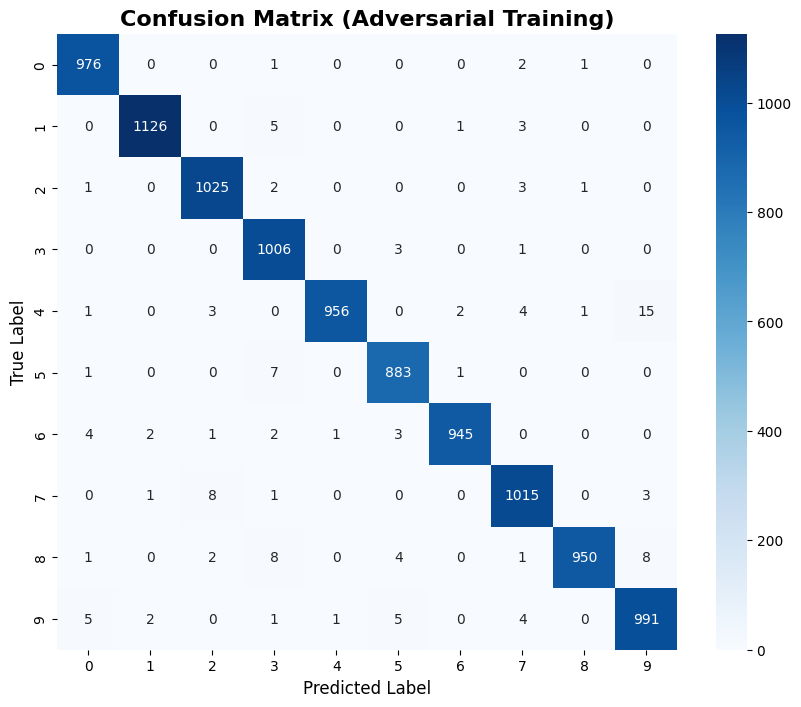

array([[ 976,    0,    0,    1,    0,    0,    0,    2,    1,    0],
       [   0, 1126,    0,    5,    0,    0,    1,    3,    0,    0],
       [   1,    0, 1025,    2,    0,    0,    0,    3,    1,    0],
       [   0,    0,    0, 1006,    0,    3,    0,    1,    0,    0],
       [   1,    0,    3,    0,  956,    0,    2,    4,    1,   15],
       [   1,    0,    0,    7,    0,  883,    1,    0,    0,    0],
       [   4,    2,    1,    2,    1,    3,  945,    0,    0,    0],
       [   0,    1,    8,    1,    0,    0,    0, 1015,    0,    3],
       [   1,    0,    2,    8,    0,    4,    0,    1,  950,    8],
       [   5,    2,    0,    1,    1,    5,    0,    4,    0,  991]])

In [25]:
print("\nGenerating confusion matrix...")
visualize_confusion_matrix(y_true, y_pred)

In [26]:
print_classification_report(y_true, y_pred)


Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       1.00      0.99      0.99      1135
           2       0.99      0.99      0.99      1032
           3       0.97      1.00      0.98      1010
           4       1.00      0.97      0.99       982
           5       0.98      0.99      0.99       892
           6       1.00      0.99      0.99       958
           7       0.98      0.99      0.98      1028
           8       1.00      0.98      0.99       974
           9       0.97      0.98      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000




Visualizing sample test set predictions...


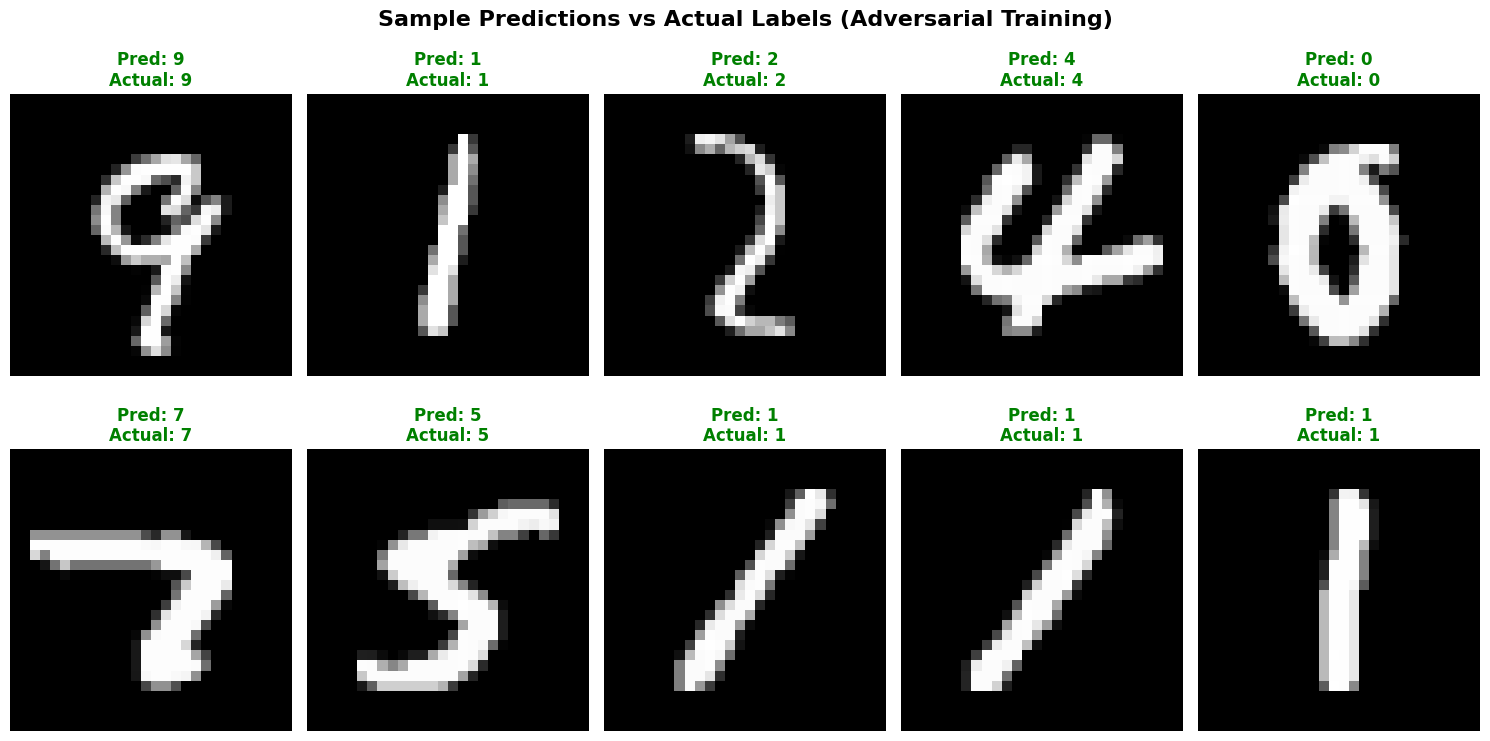

In [27]:
print("\nVisualizing sample test set predictions...")
visualize_sample_predictions(model, test_dataset, device)